# Case Study: ENCODE Long Read Sequel2 dataset

This tutorial guides through a typical Long Read Transcriptome Sequencing (LRTS) analysis workflow with isotools, 
using ENCODE Isoseq Sequel2 Data. It demonstrates the analysis of alternative splicing events within and between sample groups. 

The original analysis integrates quite a large number of samples, and consequently runs several hours. Users interested in reproducing the notebook should consider restricting the data to the samples they are interested in.

## Preparation
In this notebook, "long read RNA-seq" samples are downloaded from ENCODE to the "encode" subdirectory. You can also manually download the files using the data portal (https://www.encodeproject.org/) and download aligned .bam files. Here I use all Sequel II samples leukemia and b-cell samples the time of writing, but you can choose to process a subset. 

Further, you need a reference annotation and a genome fastq file. Please see the Alzheimer tutorial how to get these files. 

## Data import

In [1]:

from  isotools import Transcriptome
from isotools import __version__ as isotools_version
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import logging
from collections import Counter
from urllib.request import urlretrieve
import pysam

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isootools version {isotools_version}')


INFO:This is isootools version 0.2.7


In [2]:
#I assume the encode data (e.g. the bam files) are in an subdirctory "encode"
#If not, they will be downloaded
Path('./encode').mkdir(parents=True, exist_ok=True) 

#first, check what samples are present
metadata_link="https://www.encodeproject.org/metadata/?type=Experiment&assay_title=long+read+RNA-seq&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&files.file_type=bam&files.file_type=fastq&advancedQuery=date_released%3A%5B2009-02-01+TO+2021-12-31%5D&searchTerm=long+read+RNA-seq"
metadata=pd.read_csv(metadata_link, sep='\t')
platform=metadata.set_index('Experiment accession').Platform.dropna().to_dict()
for pf,count in Counter(platform.values()).items():
    logging.info(f'{pf}: In total {count} samples from ENCODE')

#Select the samples from the metadata, make sure there are only bam files are in the table
samples=metadata[(metadata['Output type']=='alignments') & (metadata['File Status']=='released')].copy()
samples['Platform']=[platform.get(ea,'unknown') for ea in samples['Experiment accession']] #This info is missing for some files
samples=samples[['File accession','Output type','Biosample term name','Biosample type','Technical replicate(s)','Platform']].reset_index(drop=True) 

#we select all leukemia and b-cell SequelII files - adjust this as needed
kariotype={"K562":'leukemia', "GM12878":'normal', "HL-60":'leukemia'}
samples=samples.query('Platform == "Pacific Biosciences Sequel II" and `Biosample term name` in ["K562", "GM12878", "HL-60"]')
samples=samples.sort_values('Biosample term name').reset_index(drop=True) 


# define the paths for reference and annotation files
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
chrom=[f'chr{i+1}'for i in range(22)]+['chrX','chrY']

#download and index the selected files, if not present
for accession in samples['File accession']:
    bam=f"encode/{accession}.bam"
    bai=bam+'.bai'
    if not os.path.isfile(bam):
        logger.info(f'downloading bam file for {accession}')
        url=metadata.loc[metadata['File accession']==accession,'File download URL'].values[0]
        file=os.path.split(url)[1]
        urlretrieve(url, f"encode/{file}")
    if not os.path.isfile(bai) or os.path.getmtime(bam)>os.path.getmtime(bai):
        logger.info(f'indexing {accession}')
        pysam.index(bam)

        
#print the sample table
samples

INFO:Oxford Nanopore PromethION: In total 4 samples from ENCODE
INFO:Pacific Biosciences Sequel: In total 16 samples from ENCODE
INFO:Pacific Biosciences Sequel II: In total 58 samples from ENCODE
INFO:Oxford Nanopore MinION: In total 11 samples from ENCODE
INFO:downloading bam file for ENCFF648NAR
INFO:indexing ENCFF648NAR
INFO:downloading bam file for ENCFF225CCJ
INFO:indexing ENCFF225CCJ
INFO:downloading bam file for ENCFF219UJG
INFO:indexing ENCFF219UJG
INFO:downloading bam file for ENCFF810FRP
INFO:indexing ENCFF810FRP
INFO:downloading bam file for ENCFF600MGT
INFO:indexing ENCFF600MGT
INFO:downloading bam file for ENCFF322UJU
INFO:indexing ENCFF322UJU
INFO:downloading bam file for ENCFF661OEY
INFO:indexing ENCFF661OEY
INFO:downloading bam file for ENCFF645UVN
INFO:indexing ENCFF645UVN


,File accession,Output type,Biosample term name,Biosample type,Technical replicate(s),Platform
0,ENCFF648NAR,alignments,GM12878,cell line,1_1,Pacific Biosciences Sequel II
1,ENCFF225CCJ,alignments,GM12878,cell line,2_1,Pacific Biosciences Sequel II
2,ENCFF219UJG,alignments,GM12878,cell line,1_1,Pacific Biosciences Sequel II
3,ENCFF810FRP,alignments,HL-60,cell line,1_1,Pacific Biosciences Sequel II
4,ENCFF600MGT,alignments,HL-60,cell line,2_1,Pacific Biosciences Sequel II
5,ENCFF322UJU,alignments,K562,cell line,1_1,Pacific Biosciences Sequel II
6,ENCFF661OEY,alignments,K562,cell line,1_1,Pacific Biosciences Sequel II
7,ENCFF645UVN,alignments,K562,cell line,2_1,Pacific Biosciences Sequel II


In [3]:
try:    
    isoseq=Transcriptome.load(f'encode/encode_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz')
        isoseq.save_reference(anno+'.isotools.pkl')
    for i,row in samples.iterrows():
        sname=f"{row['Biosample term name']}_{row['Technical replicate(s)']}".replace(' ','_')
        if sname in isoseq.samples:
            l=ord('b')
            while f'{sname}_{l:c}' in isoseq.samples:
                l+=1
            sname=f'{sname}_{l:c}'
        grp=row['Biosample term name'] 
        isoseq.add_sample_from_bam(f"encode/{row['File accession']}.bam", 
                                   use_satag=True,
                                   sample_name=sname , 
                                   group=grp,
                                   kariotype=kariotype[grp],
                                   sample_type=row['Biosample type'],
                                   platform=row['Platform']) 
    isoseq.add_qc_metrics(genome) #3:41 min
    isoseq.make_index()
    isoseq.save('encode/encode_isotools.pkl')


INFO:loading transcriptome from encode/encode_isotoolsXXX.pkl
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotoolsXXX.pkl
INFO:importing reference from gff3 file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.gff3.gz
3270946it [01:59, 27434.88it/s]
INFO:skipped the following categories: {'three_prime_UTR', 'CDS', 'five_prime_UTR', 'stop_codon_redefined_as_selenocysteine'}
INFO:saving reference to reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample GM12878_1_1 from file encode/ENCFF648NAR.bam
100%|██████████| 2039578.0/2039578 [05:39<00:00, 6016.14reads/s, chr=ERCC-00171]             
INFO:ignoring 11145 chimeric alignments with less than 2 reads
INFO:imported 2029866 nonchimeric reads (including  1879 chained chimeric alignments) and 362 chimeric reads with coverage of at least 2.
INFO:adding sample GM12878_2_1 from file encode/ENCFF225CCJ.bam
100%|██████████| 2442854.0/244285

In [5]:
#add gencode specific filters

isoseq.add_filter( "HIGH_SUPPORT", 'transcript_support_level=="1"', context='reference')
isoseq.add_filter( "PROTEIN_CODING", 'transcript_type=="protein_coding"', context='reference')


## Saturation Anlalysis
To estimate the saturation of discovered isoforms, IsoTools offers two complimentary figures: 
* The saturation plot models the expected probability of discovering a transcript 
    * at given level of confidence (number of supporting long reads) 
    * which is present at a given abundance level in the sample (in transcripts per milion, TPM)
    * depending on the total number of long reads
* The rarefaction analysis depicts the number of different discovered transcripts when subsampling the long reads

The saturation analysis reveals that at the given sequencing depth, transcripts expressed at 2 TPM have > 80% probability of beeing covered by at least two reads in the individual samples, while transcripts expressed at 1 TPM have 40% to 75% probability. The slope of the rarefaction curve at the right end reflects the number of novel transcripts that could be discovered if sequencing depth would be increased. 

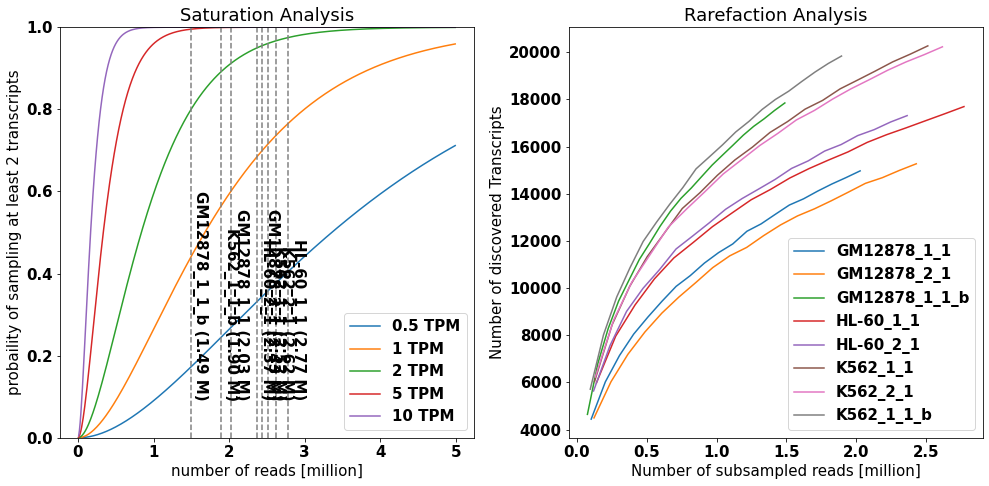

In [6]:
from isotools.plots import plot_saturation, plot_rarefaction
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (14,7)
fig, axs=plt.subplots(1,2)

plot_saturation(isoseq,cov_th=2, x_range=(1e4,5e6,1e4), ax=axs[0])

rarefraction, total=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
plot_rarefaction(rarefraction, total=total, ax=axs[1])

fig.tight_layout()

## Quality control and filtering
First, we will depict some quality metrics and define filtering criteria. For more information on technical artifacts, quality metrics, and filtering, see the Alzheimer tutorial. 

In [7]:
#compute some summary statistics on technical artifacts. 
# For this analysis samples are grouped by 'Biosample term name'
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( query='not NOVEL_GENE'), ref_filter=dict(query='HIGH_SUPPORT')),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( query='not NOVEL_TRANSCRIPT'), ref_filter=dict(query='not REF_UNSPLICED')),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(query='NOVEL_GENE and UNSPLICED')),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats(tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'], groups=isoseq.groups(), weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

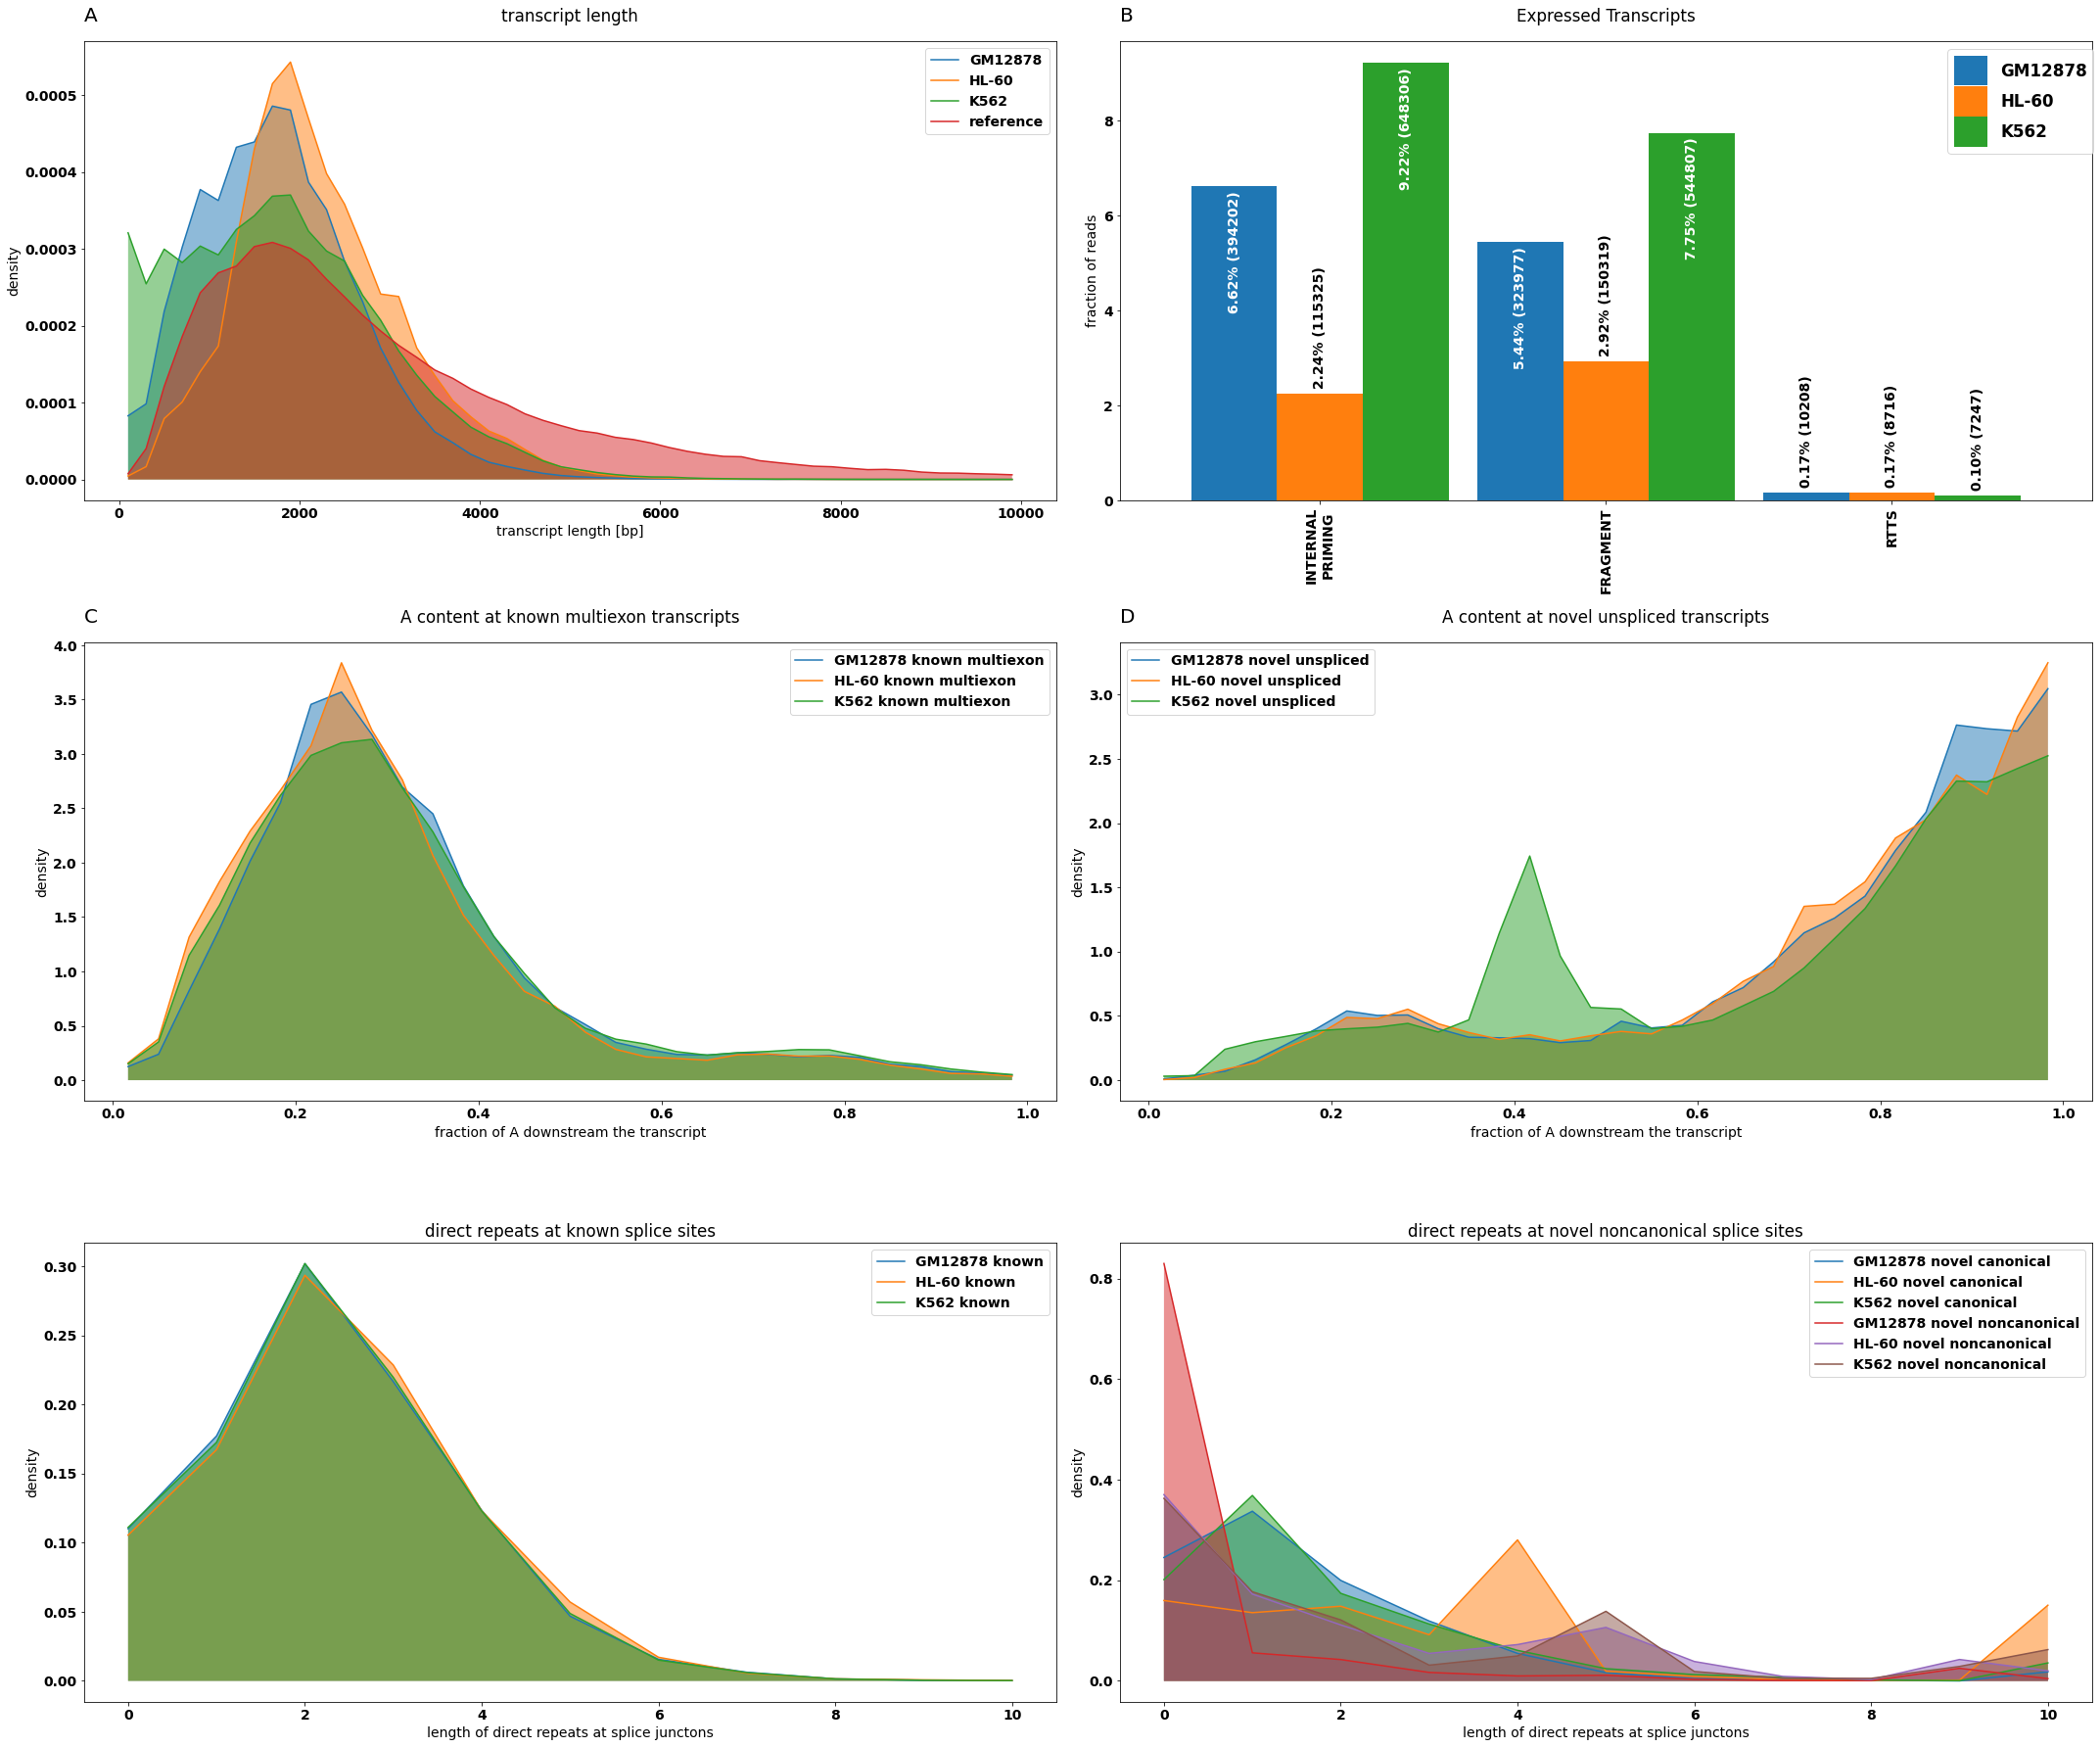

In [8]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],legend=True,**tr_stats[0][1])  
#B) frequency of artifacts
plot_bar(f_stats[0],ax=axs[0,1],drop_categories=['PASS'],bar_width=.9,legend=True,**f_stats[1])  
#C/D) internal priming
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,0],legend=True,density=True,fill=True, title= 'A content at known multiexon transcripts', xlabel='fraction of A downstream the transcript')  
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,1],legend=True,density=True,fill=True, title= 'A content at novel unspliced transcripts', xlabel='fraction of A downstream the transcript')  
#E/F) RTTS
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[2,0],legend=True,density=True,title='direct repeats at known splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[2,1],legend=True,density=True,title='direct repeats at novel noncanonical splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
fig.tight_layout()
axs[0,1].legend(fontsize='large', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.01, 1))


In [9]:
f_stats_sample=isoseq.filter_stats(tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'], weight_by_coverage=True,min_coverage=1)


Quality metrics vary substantially between the individual samples, in particular for internal priming artifacts. On the other hand, RRTS seems to be almost absent in this data, indicating that the alignments may have been filtered. The fractions of affected reads for the different artifacts can be depicted as a bar chart.

<AxesSubplot:title={'center':'Expressed Transcripts'}, ylabel='fraction of reads'>

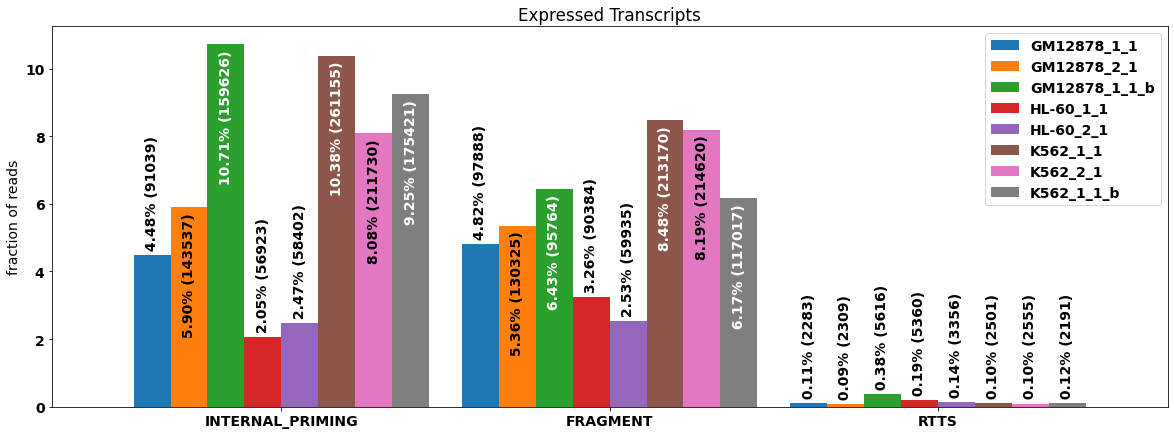

In [10]:
#plot technical artifacts for individual samples
plt.rcParams["figure.figsize"] = (20,7)
plot_bar(f_stats_sample[0],drop_categories=['PASS'],legend=True,rot=0, bar_width=.9,**f_stats_sample[1])  
#plt.legend(fontsize='small', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')

## Data exploration
To explore the relation of the samples with respect to splicing we look at PCA and UMAP embeddings based on alternative splicing events.

In [11]:
#Compute alternative splicing events by finding "bubbles" in the segment graphs
splice_events=isoseq.alternative_splicing_events()

/home/lienhard/.local/lib/python3.9/site-packages/isotools/plots.py:153: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  p = ((k.values + scaled_mean[:, np.newaxis]) / (n.values + prior_count)).T
/home/lienhard/.local/lib/python3.9/site-packages/isotools/plots.py:153: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  p = ((k.values + scaled_mean[:, np.newaxis]) / (n.values + prior_count)).T
/home/lienhard/.local/lib/python3.9/site-packages/isotools/plots.py:153: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  p = ((k.values + scaled_mean[:, np.newaxis]) / (n.values + prior_count)).T
/hom

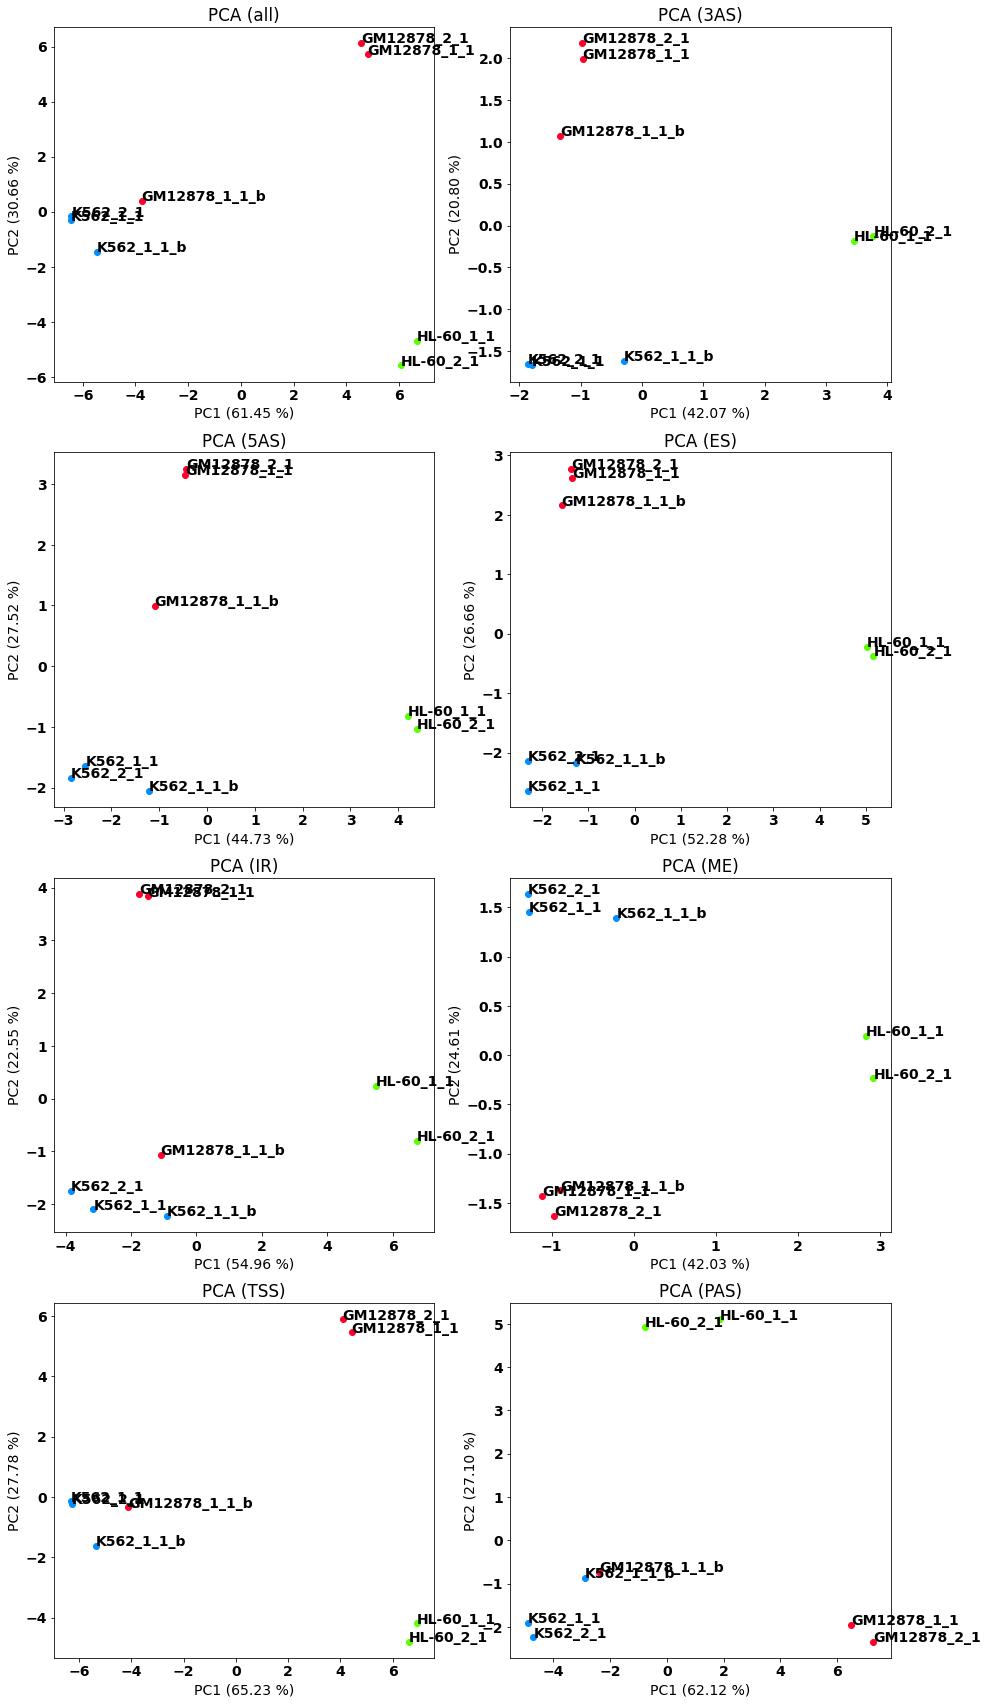

In [12]:
#plot PCA embedding
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (15,30)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events, ax=ax, labels=True, groups=isoseq.groups(), splice_types=t)
    

#axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')
#plt.tight_layout()


/home/lienhard/.local/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'FileNotFoundError([Errno 2] No such file or directory: '/home/lienhard/.local/lib/python3.9/site-packages/numba-0.54.0.dist-info/METADATA')'.
  numba.core.entrypoints.init_all()
2021-12-02 14:26:16.740711: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/lienhard/.local/lib/python3.9/site-packages/isotools/plots.py:153: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  p = ((k.values + scaled_mean[:, np.newaxis]) / (n.values + prior_count)).T
/home/lienhard/.local/lib/python3.9/site-packages/isotools/plots.py:153: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a

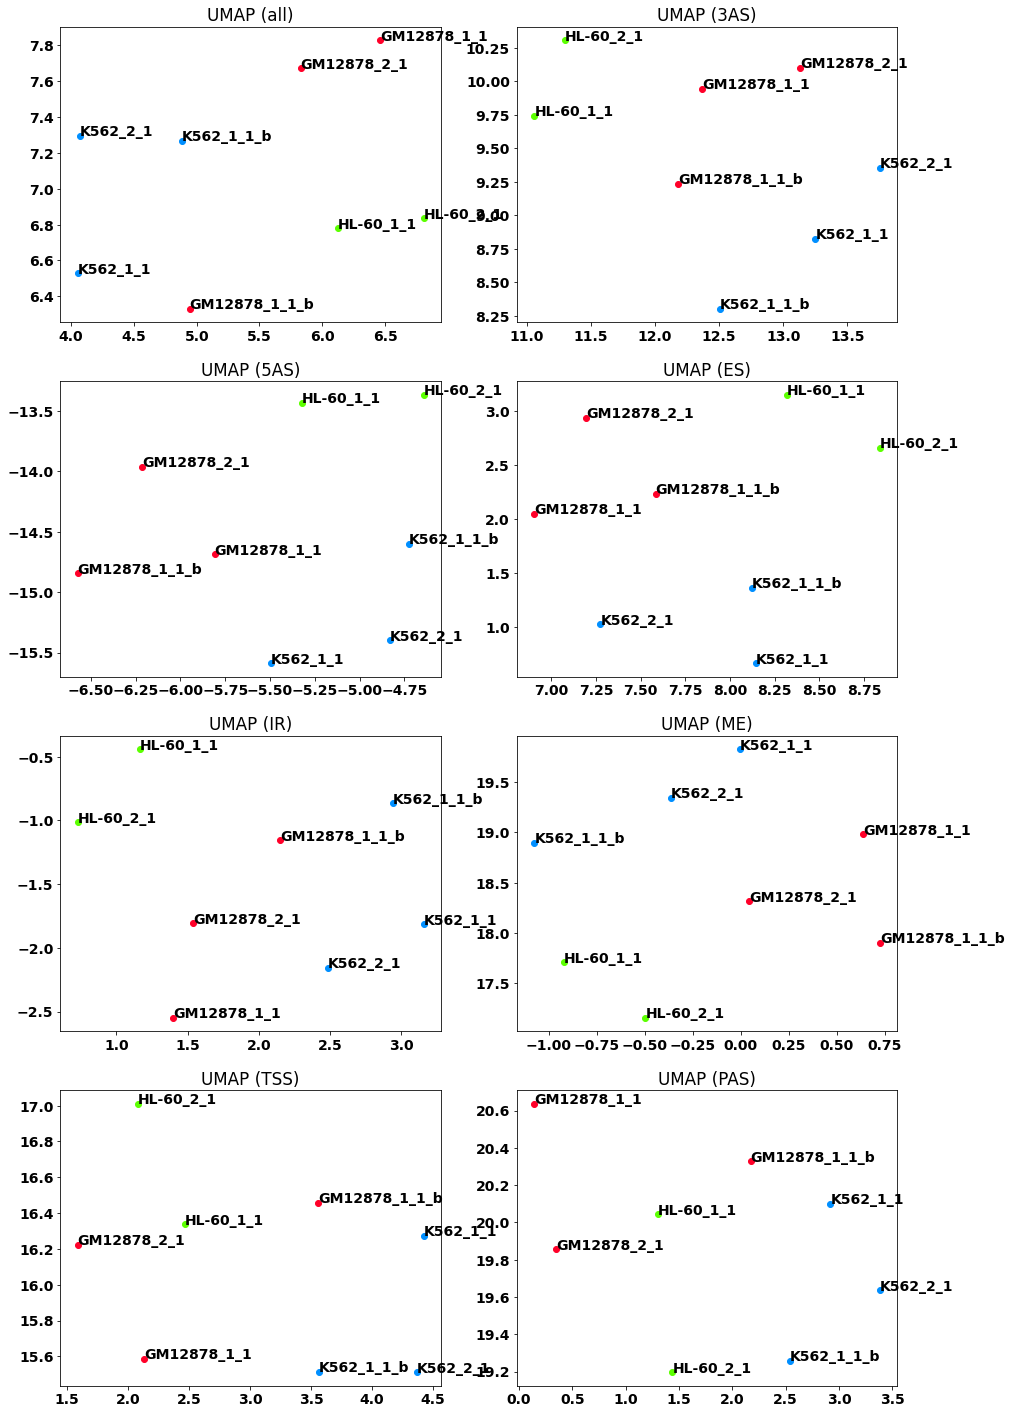

In [13]:
#plot UMAP embedding 
# the clustering of samples very much depends on the n_neighbors parameter
plt.rcParams["figure.figsize"] = (15,25)
umap={}
f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    umap[t]=plot_embedding(splice_events, method='UMAP',n_neighbors=6, ax=ax, labels=True, groups=isoseq.groups(), splice_types=t)
    

#xs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')


## Novel alternative splicing classification

In [14]:

from isotools.transcriptome import SPLICE_CATEGORY
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( query='not (RTTS or FRAGMENT or INTERNAL_PRIMING)')),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( query='not (RTTS or FRAGMENT or INTERNAL_PRIMING)')),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( query='not (RTTS or FRAGMENT or INTERNAL_PRIMING)'))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({SPLICE_CATEGORY[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

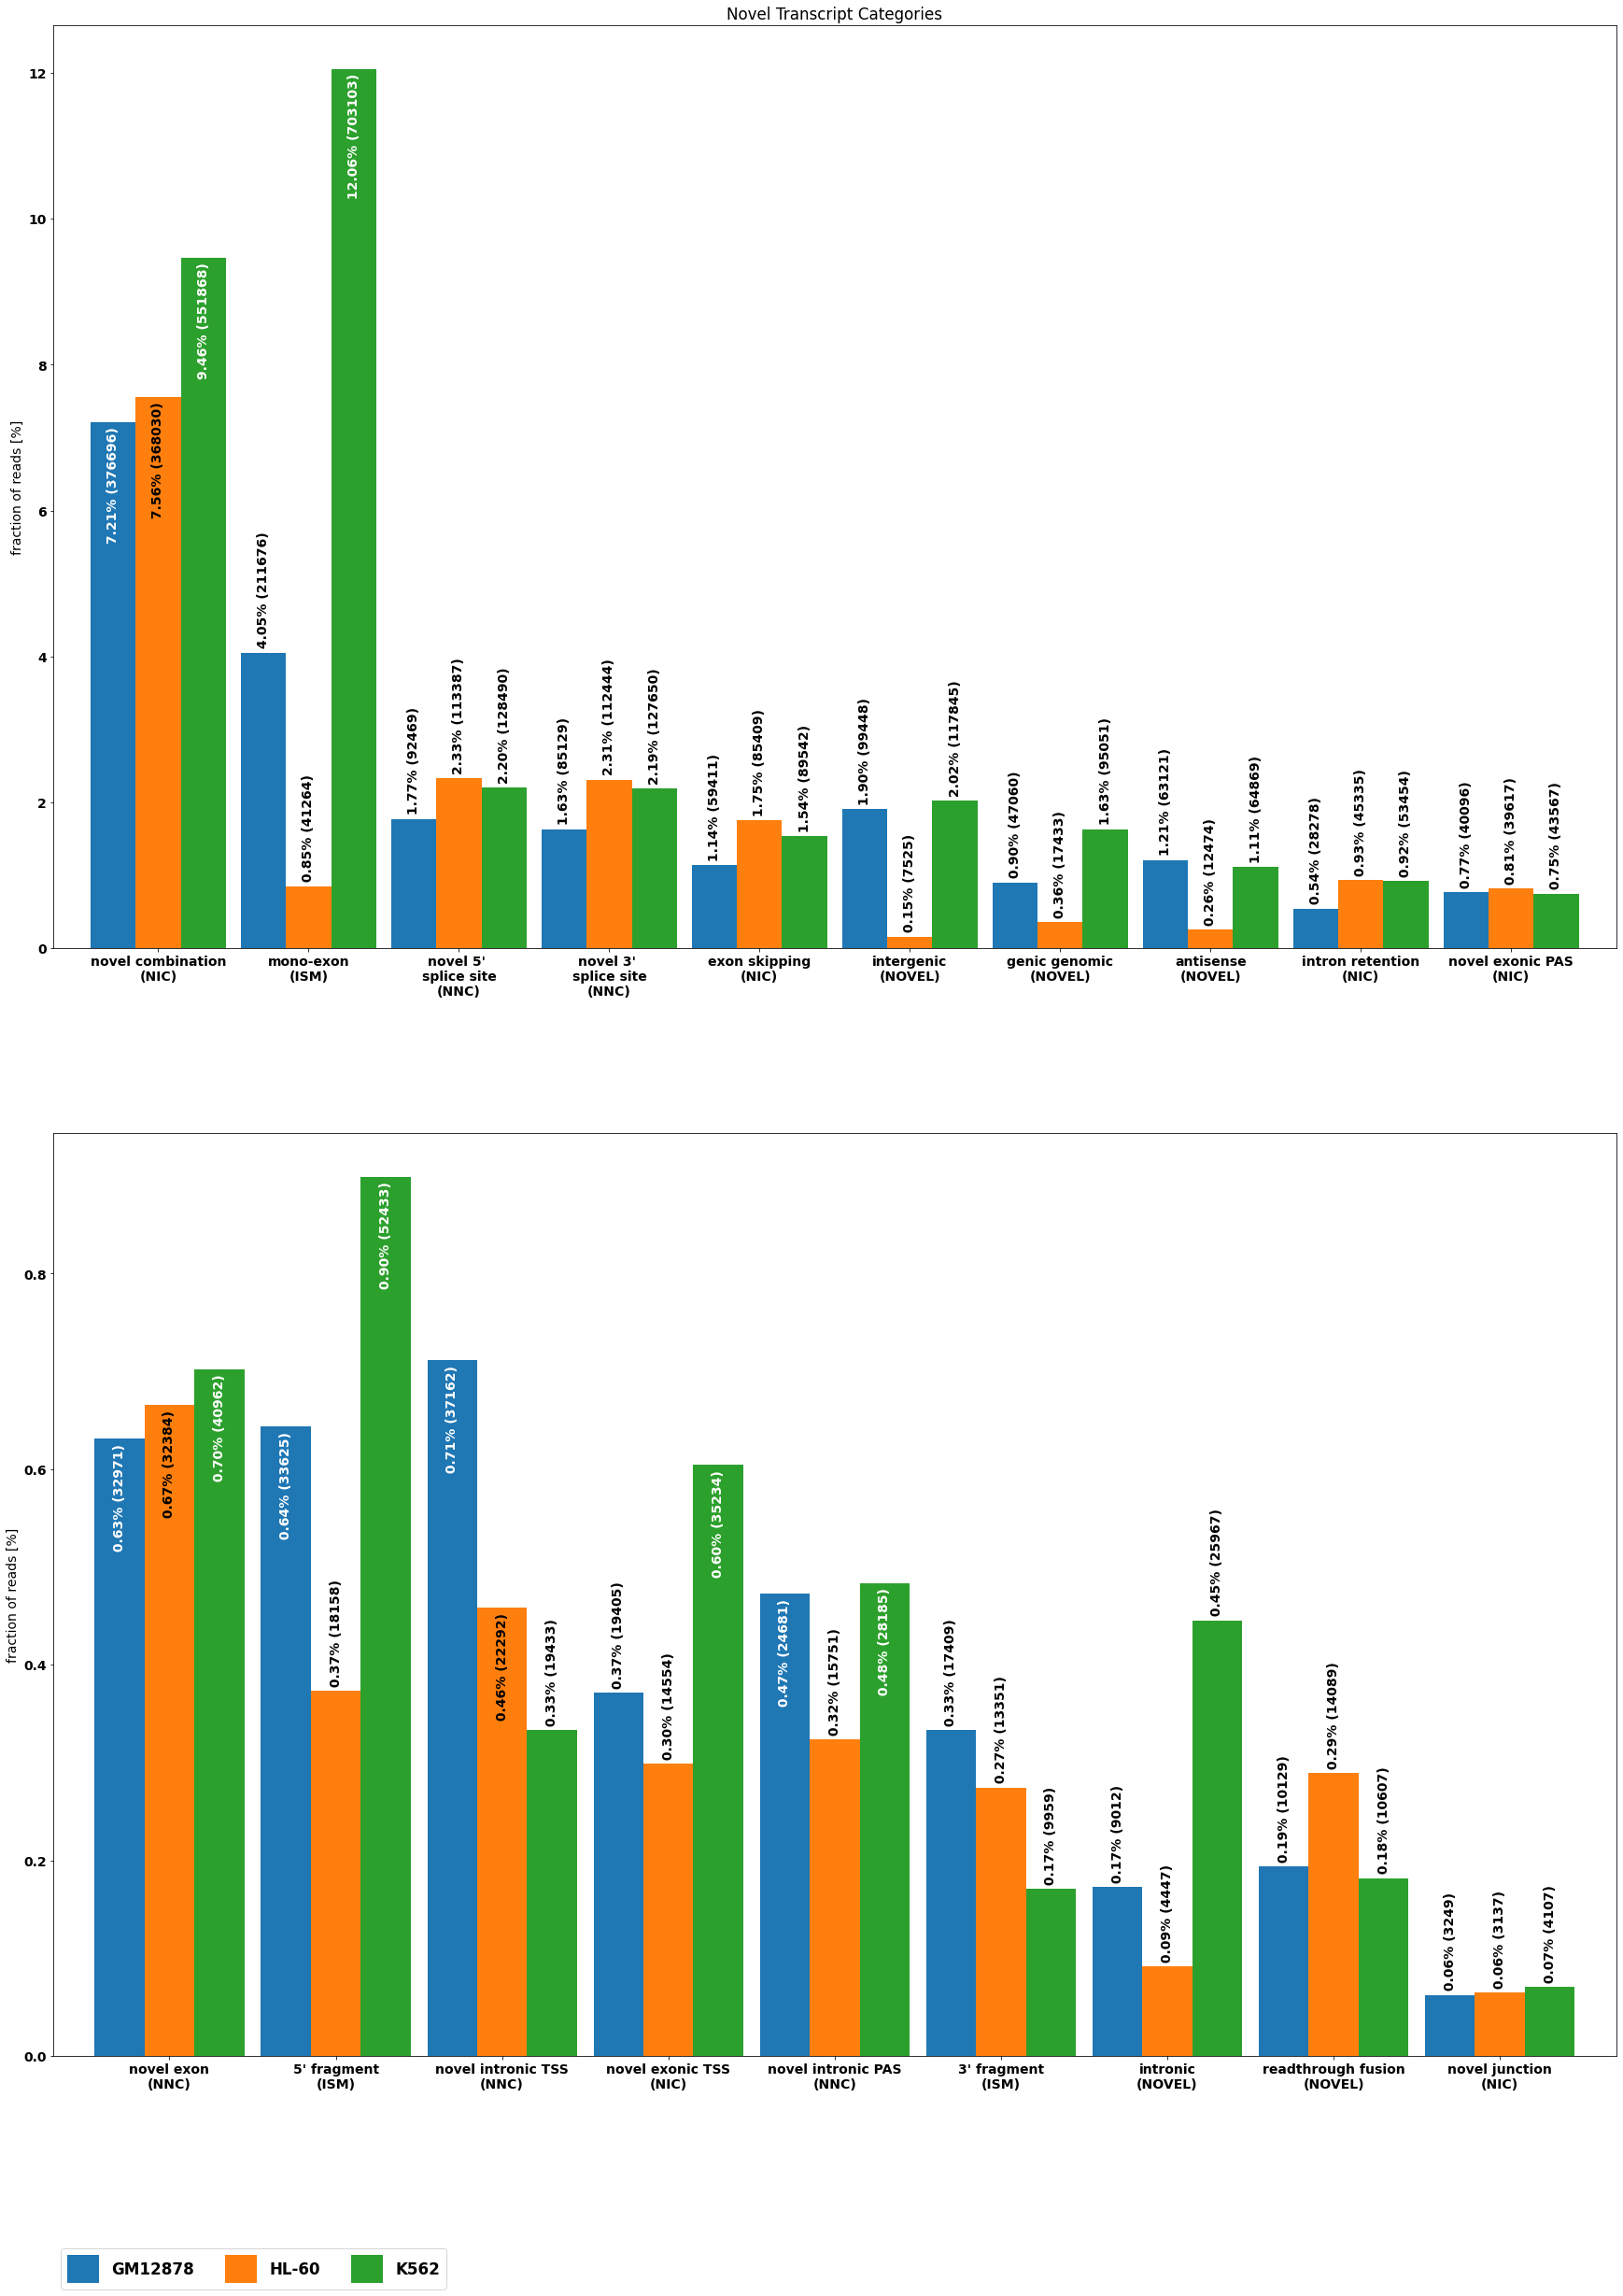

In [15]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,40)
fig, axs = plt.subplots( 2)
for i,ax in enumerate(axs):
    cat=altsplice[0][0].index[i*10+2:(i+1)*10+2]
    plot_bar(altsplice[0][0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice[0][0].index if c not in cat])  
axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

In [16]:
#The same for individual samples
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict(  query='not (RTTS or FRAGMENT or INTERNAL_PRIMING)'))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({SPLICE_CATEGORY[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


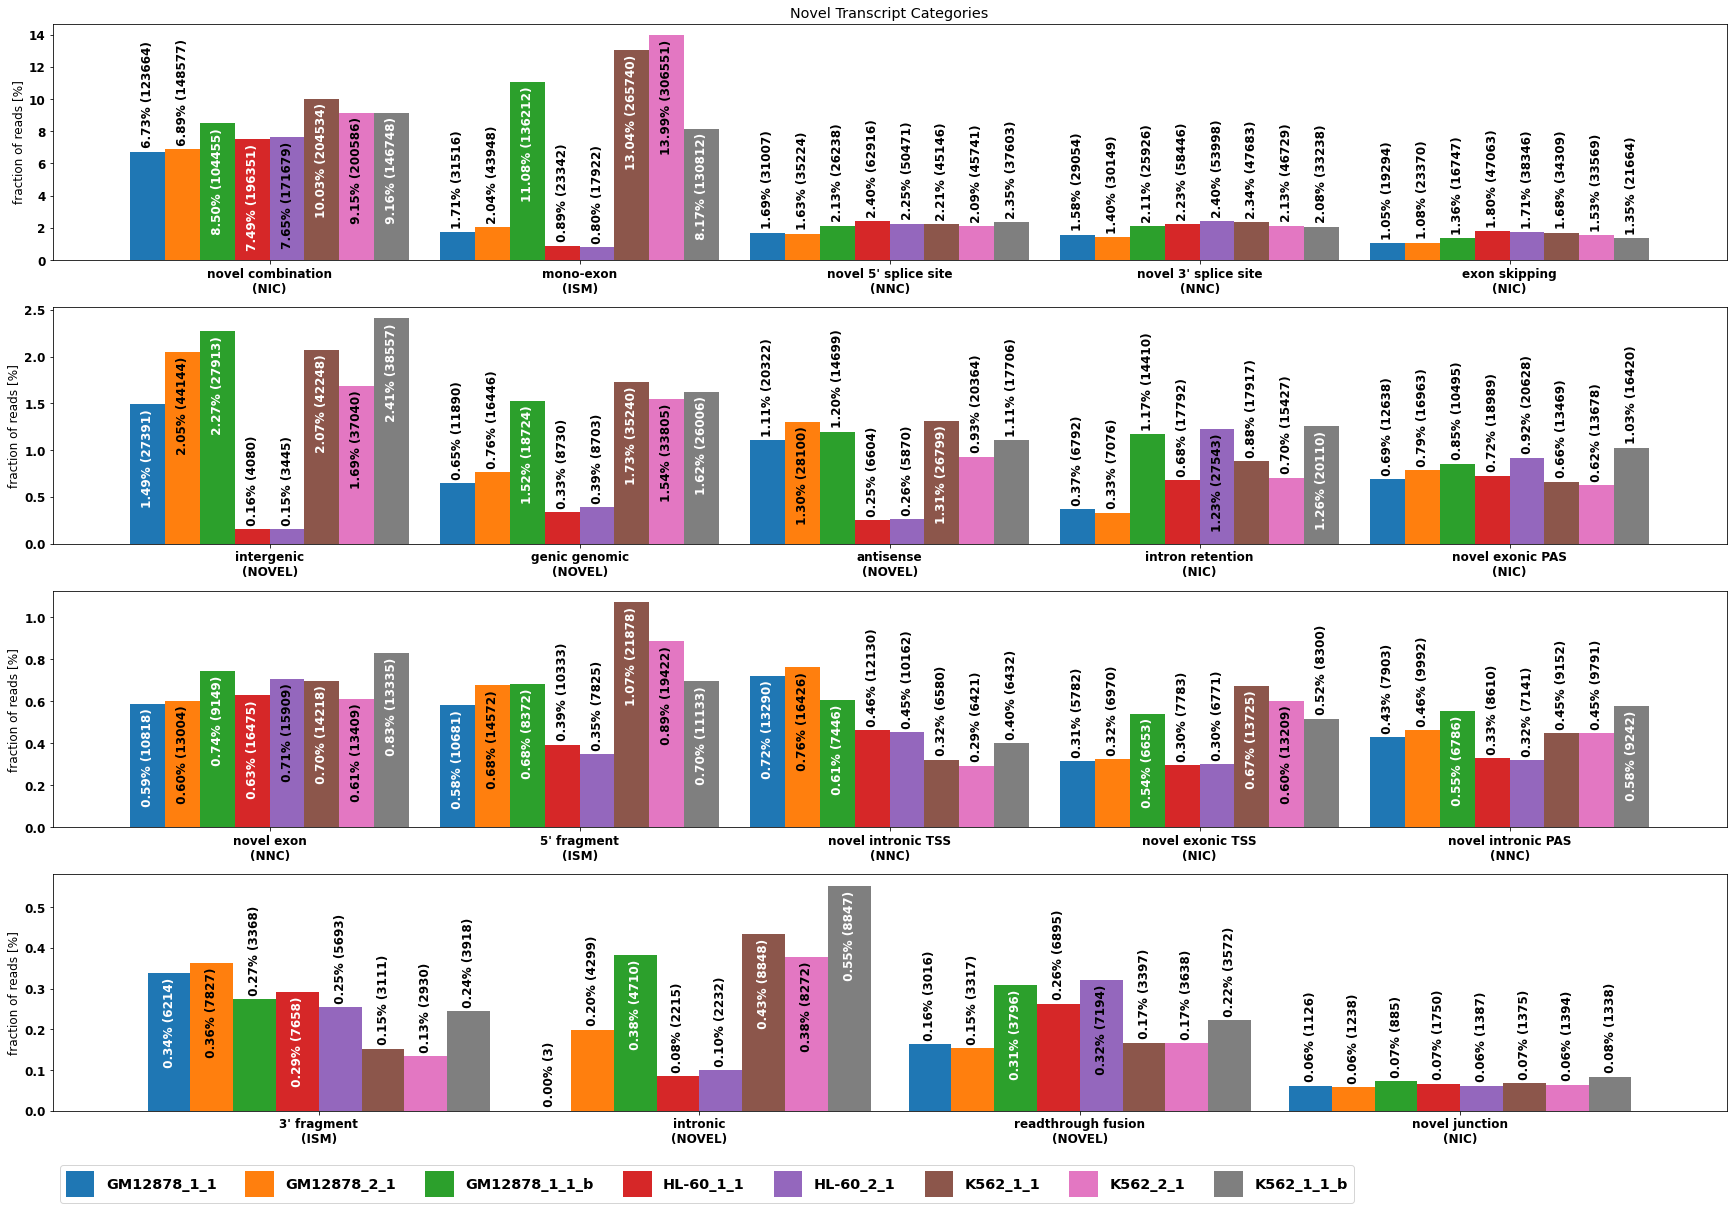

In [17]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots( 4)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*5+2:(i+1)*5+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()

axs[-1].legend(fontsize='large', ncol=8,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

## Differential splicing

To test for differential splicing events between groups of samples, IsoTools implements a likelihood ratio test based on beta binomial distribution. 
For each alternative event, the number of reads supporting the alternative is modeled with a binomial distribution, where the probability parmeter is beta distributed. For the null model, we fit one set of maximum likelihood parameters of the beta distribution for all samples, whereas for the alternative model, a set of parameters if fitted for each group. Under the null hypothesis, the model deviance is assumed to follow a chi2 distribution with two degrees of freedom.

Each comparision results in table of alternative splicing events, sorted by significance. 
To explore the results, we can plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
We can also look at individual examples and depict the event as a sashimi plot. 
To this end, we define a helper function, to automatically identify the relevant region and the involved junctions and make the sashimi plot:


In [18]:
#first we define a function, to depcit the results
def plot_diff_example(row, isoseq, groups):
    #sashimi plot for differential spliced genes
    plt.rcParams["figure.figsize"] = (15,10)
    #select gene object
    g=isoseq[row.gene_id]
    #make the title
    gn=list(groups)
    novel='novel' if row.novel else 'known'
    title=f'{g.name} {row.splice_type} ({novel}) FDR={row.padj:.2e}: {gn[0]}={row[gn[0]+"_PSI"]*100:.1f} vs {gn[1]}={row[gn[1]+"_PSI"]*100:.1f} PSI'
    print(title)
    start=row.start
    end=row.end
    #select the junctions of interest (which will be marked purple in the plot)
    joi=[(start,end)]
    if row.splice_type=='ME' and g.is_annotated:
        try:
            sg=g.ref_segment_graph
            n1=next(n for n in sg if n[1]==start)
            n2=next(n for n in sg if n[0]==end)
            joi={(start,sg[suc].start) for suc in n1.suc.values() if sg[suc].start<end }
            joi.update({(sg[pre].end,end) for pre in n2.pre.values() if sg[pre].end>start })
        except:
            pass
    #draw the plot for the two sample groups from the comparison
    f,axs=g.sashimi_figure(samples=groups , x_range=(start-500, end+500),junctions_of_interest=joi    )
    axs[0].set_title(title)
    fig.tight_layout()

In [19]:
from isotools.plots import plot_diff_results
#We are mostly interested in differential splicing. Alternative TSS and PAS are ignored for now. 
types_of_interest=['ES','ME','5AS','3AS']
#dict to store the results in
res={}

### Leukemia cell lines
Both leukemia cell lines HL-60 and K562 (should) have mutations in the splicing machinery, e.g. in the SRSF2 gene, which should lead to abberant splicing compared to the B-cell derived cell line GM12878.

See Urbanski et al: Alternative-splicing defects in cancer: splicing regulators and their downstream targets, guiding the way to novel cancer therapeutics
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002934/


In [20]:
diff_cmp='GM12878/HL-60'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}
#perform the test:
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
#write result table
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs HL-60 (2) using betabinom_lr test
100%|██████████| 309557/309557 [09:40<00:00, 533.66genes/s]


5659 differential splice sites in 3329 genes for GM12878 vs HL-60


,index,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,...,GM12878_1_1_GM12878_in_cov,GM12878_1_1_GM12878_total_cov,GM12878_2_1_GM12878_in_cov,GM12878_2_1_GM12878_total_cov,GM12878_1_1_b_GM12878_in_cov,GM12878_1_1_b_GM12878_total_cov,HL-60_1_1_HL-60_in_cov,HL-60_1_1_HL-60_total_cov,HL-60_2_1_HL-60_in_cov,HL-60_2_1_HL-60_total_cov
3,13046,EIF4A2,ENSG00000156976.17,chr3,+,186787882,186789124,ES,False,0.003859,...,234,708,333,966,49,132,47.0,1748.0,26.0,1205.0
4,13047,EIF4A2,ENSG00000156976.17,chr3,+,186787882,186789124,3AS,True,0.004204,...,210,684,250,883,39,122,25.0,1726.0,14.0,1193.0
9,3869,ANAPC5,ENSG00000089053.13,chr12,-,121328458,121330582,3AS,False,0.006753,...,895,1340,1169,1727,201,305,470.0,1206.0,404.0,989.0
13,15216,MCM3,ENSG00000112118.20,chr6,-,52264786,52266074,ES,False,0.006753,...,47,2403,31,1979,22,704,519.0,2363.0,443.0,1955.0
14,10047,CBWD2,ENSG00000136682.15,chr2,+,113438022,113441350,ES,False,0.006753,...,24,209,37,326,12,88,135.0,199.0,83.0,117.0
17,16292,METTL2B,ENSG00000165055.16,chr7,+,128476875,128479157,ES,False,0.006753,...,5,88,9,144,3,44,122.0,123.0,67.0,68.0
20,1711,SRP9,ENSG00000143742.14,chr1,+,225783368,225789239,ES,False,0.007374,...,95,1453,173,2368,24,266,305.0,1134.0,208.0,749.0
23,7847,WSB1,ENSG00000109046.15,chr17,+,27306882,27309099,3AS,False,0.007374,...,25,403,21,621,6,63,101.0,108.0,144.0,155.0
24,5145,ZNF410,ENSG00000119725.20,chr14,+,73921105,73923394,ES,False,0.007374,...,332,494,497,772,88,134,350.0,353.0,283.0,283.0
26,1284,LGALS8,ENSG00000116977.19,chr1,+,236542787,236543559,ES,False,0.007374,...,82,111,107,150,13,17,14.0,154.0,9.0,120.0


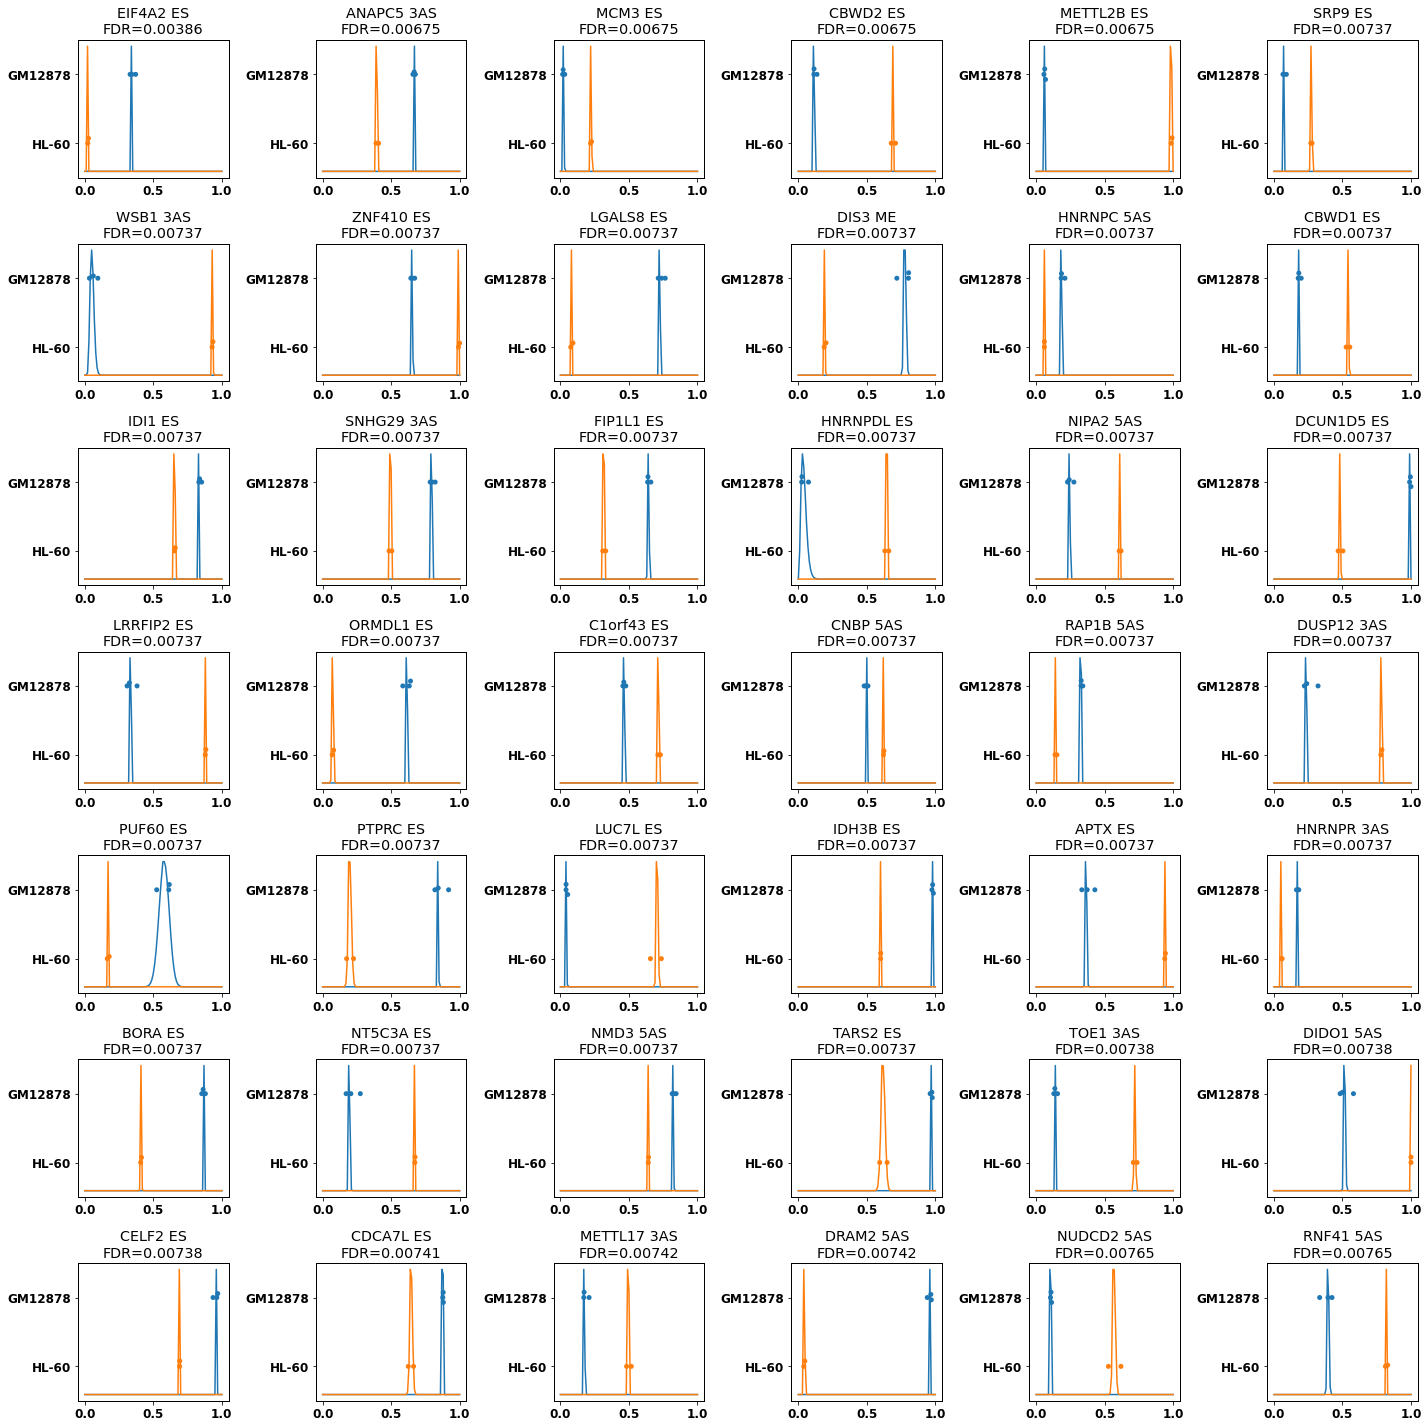

In [21]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

EIF4A2 ES (known) FDR=3.86e-03: GM12878=34.1 vs HL-60=2.5 PSI


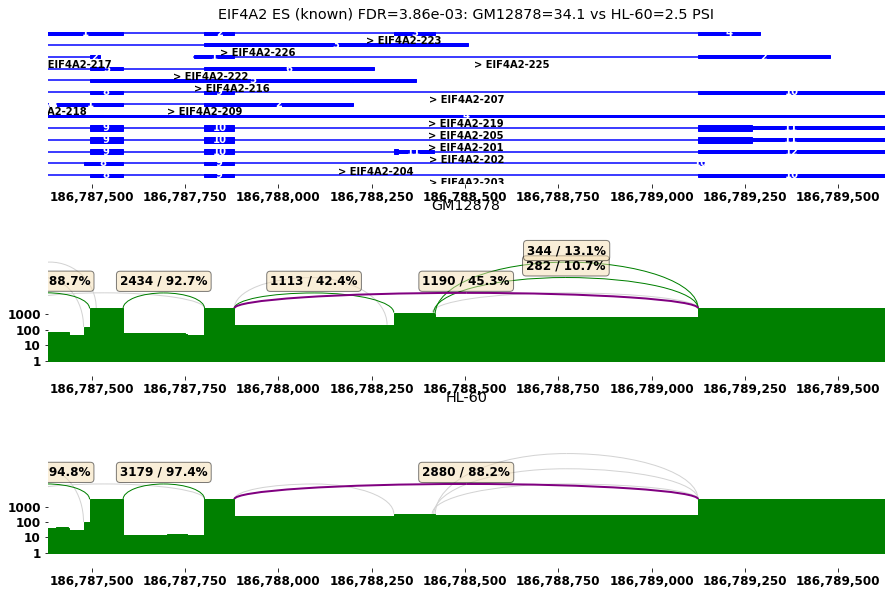

In [22]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,20)
#1) select gene of interest: 3nd row, exon skipping of EIF4A2
row=res[diff_cmp].iloc[3]
plot_diff_example(row, isoseq, groups)

In [23]:
diff_cmp='GM12878/K562'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs K562 (3) using betabinom_lr test
100%|██████████| 309557/309557 [11:48<00:00, 437.09genes/s]


4665 differential splice sites in 3050 genes for GM12878 vs K562


,index,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,...,GM12878_2_1_GM12878_in_cov,GM12878_2_1_GM12878_total_cov,GM12878_1_1_b_GM12878_in_cov,GM12878_1_1_b_GM12878_total_cov,K562_1_1_K562_in_cov,K562_1_1_K562_total_cov,K562_2_1_K562_in_cov,K562_2_1_K562_total_cov,K562_1_1_b_K562_in_cov,K562_1_1_b_K562_total_cov
0,1124,NDUFS5,ENSG00000168653.11,chr1,+,39026398,39028722,5AS,False,0.001004,...,7,634,3,199,208,372,336,580,136,249
5,20075,RIPK2,ENSG00000104312.8,chr8,+,89780160,89786592,ES,True,0.004049,...,224,225,76,76,34,104,33,112,41,152
8,616,PSMB2,ENSG00000126067.12,chr1,-,35631344,35641341,ES,True,0.005460,...,954,954,257,258,681,893,595,765,262,341
9,4998,MYL6,ENSG00000092841.19,chr12,+,56160320,56161386,ES,False,0.005460,...,24,1827,22,911,188,722,235,940,182,611
13,15657,CASP3,ENSG00000164305.19,chr4,-,184638468,184649394,ES,True,0.005645,...,197,958,26,111,71,105,75,119,71,95
21,5028,RAD51AP1,ENSG00000111247.15,chr12,+,4553147,4558856,ES,False,0.006496,...,44,48,34,38,5,34,7,39,7,41
22,6326,HNRNPC,ENSG00000092199.18,chr14,-,21230366,21230996,5AS,False,0.006782,...,387,2092,168,799,431,1287,480,1475,361,1094
24,19040,METTL2B,ENSG00000165055.16,chr7,+,128476875,128479157,ES,False,0.006782,...,9,144,3,44,68,71,61,63,71,71
33,20288,CBWD1,ENSG00000172785.18,chr9,-,175784,178815,ES,False,0.007260,...,99,561,25,138,107,227,125,248,50,112
39,1415,MPZL1,ENSG00000197965.12,chr1,+,167773368,167787819,ES,False,0.009935,...,0,4,6,65,168,273,144,239,124,190


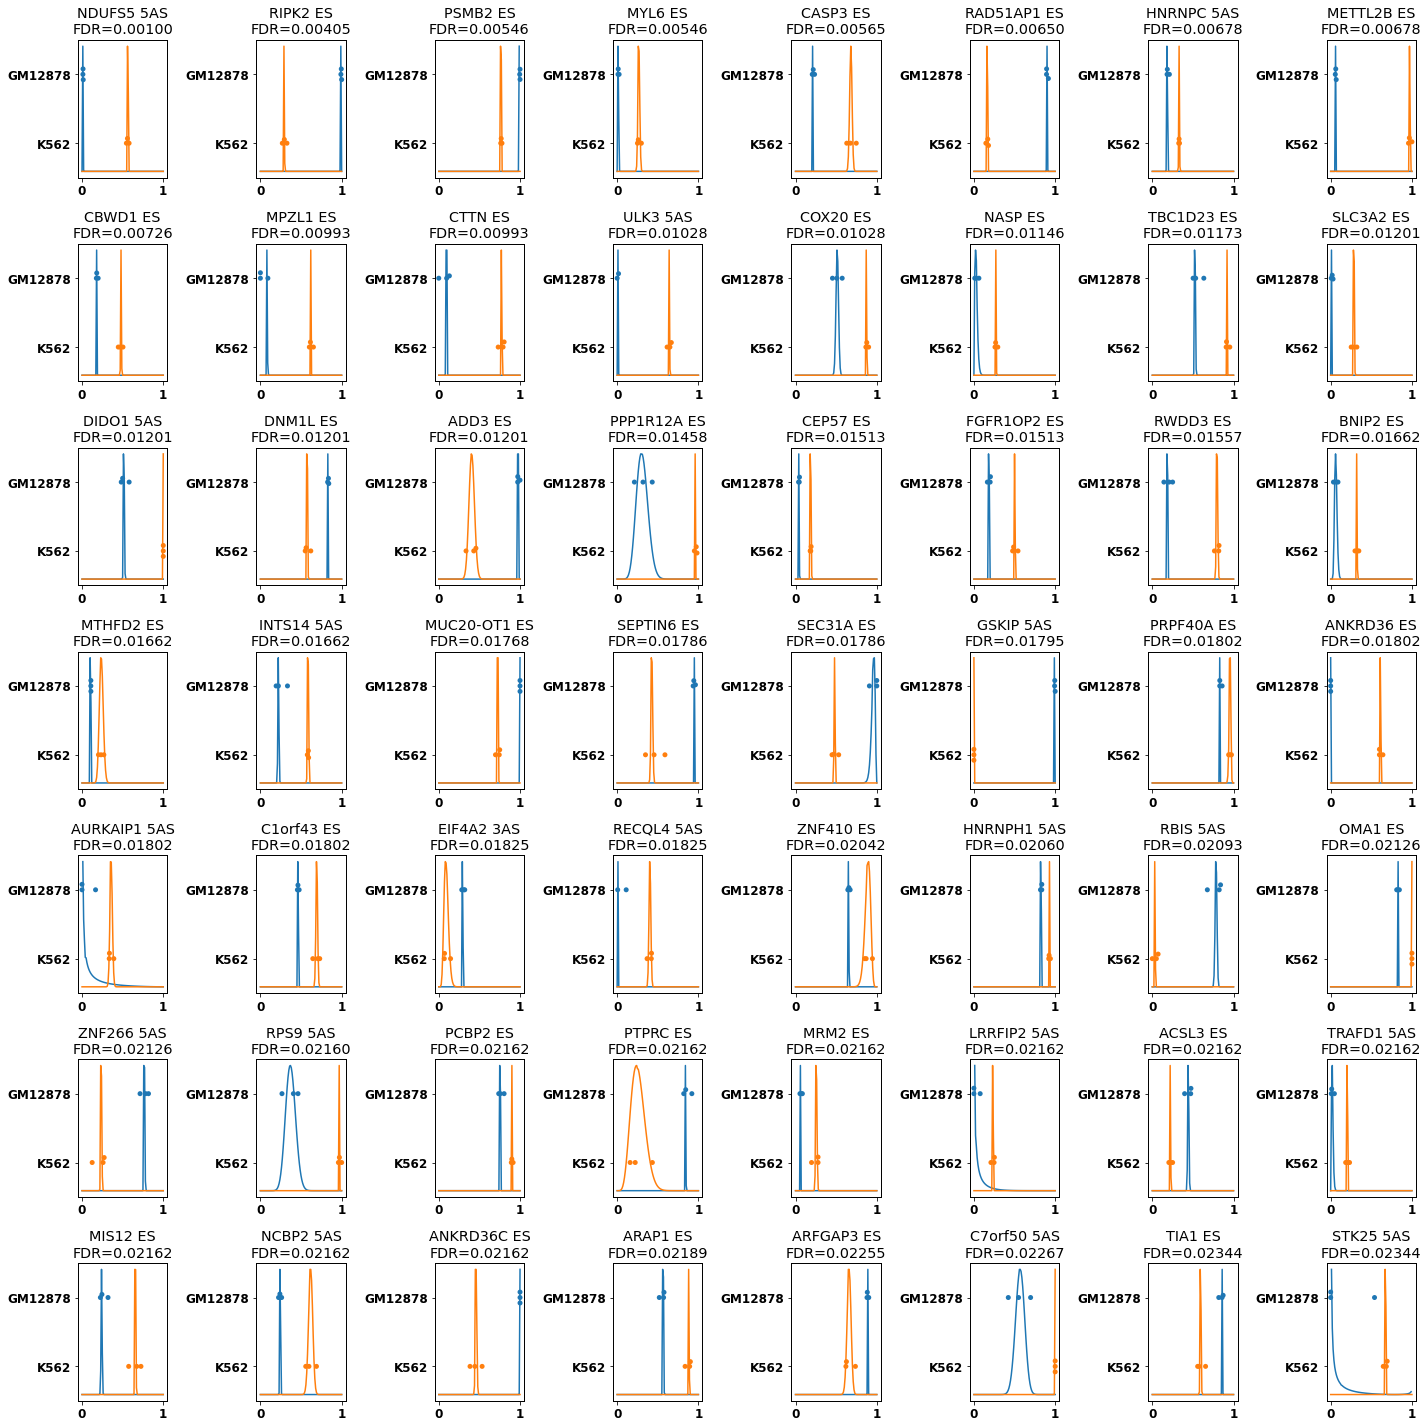

In [24]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,8),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

RIPK2 ES (novel) FDR=4.05e-03: GM12878=99.4 vs K562=29.4 PSI


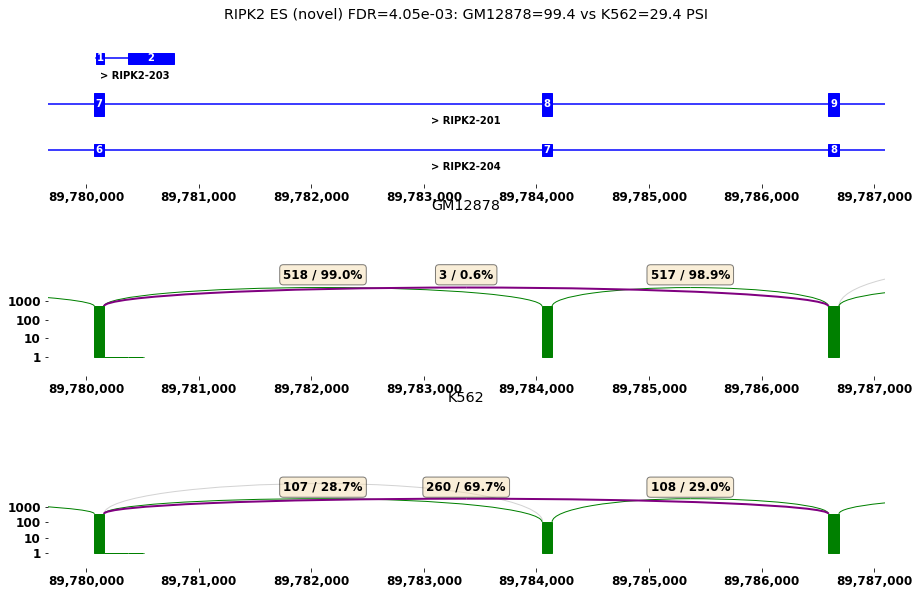

In [25]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[5]
plot_diff_example(row, isoseq, groups)

In [26]:
gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'GM12878':gr['GM12878']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs GM12878 (3) using betabinom_lr test
100%|██████████| 309557/309557 [11:50<00:00, 435.65genes/s]


1587 differential splice sites in 1181 genes for leukemia vs GM12878


,index,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,...,HL-60_1_1_leukemia_in_cov,HL-60_1_1_leukemia_total_cov,HL-60_2_1_leukemia_in_cov,HL-60_2_1_leukemia_total_cov,GM12878_1_1_GM12878_in_cov,GM12878_1_1_GM12878_total_cov,GM12878_2_1_GM12878_in_cov,GM12878_2_1_GM12878_total_cov,GM12878_1_1_b_GM12878_in_cov,GM12878_1_1_b_GM12878_total_cov
3,20601,METTL2B,ENSG00000165055.16,chr7,+,128476875,128479157,ES,False,0.001373,...,122,123,67,68,5,88,9.0,144.0,3.0,44.0
7,21875,CBWD1,ENSG00000172785.18,chr9,-,175784,178815,ES,False,0.002528,...,192,347,120,228,60,302,99.0,561.0,25.0,138.0
9,1232,NDUFS5,ENSG00000168653.11,chr1,+,39026398,39028722,5AS,False,0.002679,...,17,44,13,43,5,393,7.0,634.0,3.0,199.0
10,7656,INTS14,ENSG00000138614.15,chr15,-,65607442,65611097,5AS,False,0.003423,...,135,224,108,178,35,158,43.0,222.0,18.0,54.0
14,922,C1orf43,ENSG00000143612.21,chr1,-,154214574,154220341,ES,False,0.003568,...,1157,1627,768,1053,159,349,237.0,497.0,49.0,106.0
18,1402,ACADM,ENSG00000117054.14,chr1,+,75724817,75732643,ES,False,0.003568,...,264,325,206,256,802,836,1104.0,1159.0,155.0,164.0
28,19864,MRM2,ENSG00000122687.19,chr7,-,2235564,2239417,ES,False,0.005016,...,94,370,70,301,29,400,25.0,460.0,9.0,107.0
29,14268,DIDO1,ENSG00000101191.17,chr20,-,62914406,62926438,5AS,True,0.005016,...,175,175,156,156,38,76,28.0,58.0,29.0,50.0
30,1685,PTPRC,ENSG00000081237.20,chr1,+,198692373,198703297,ES,False,0.005016,...,67,297,58,331,186,227,259.0,307.0,57.0,62.0
32,19563,ECHDC1,ENSG00000093144.19,chr6,-,127314896,127327001,ES,False,0.005041,...,148,272,109,210,320,363,441.0,502.0,66.0,88.0


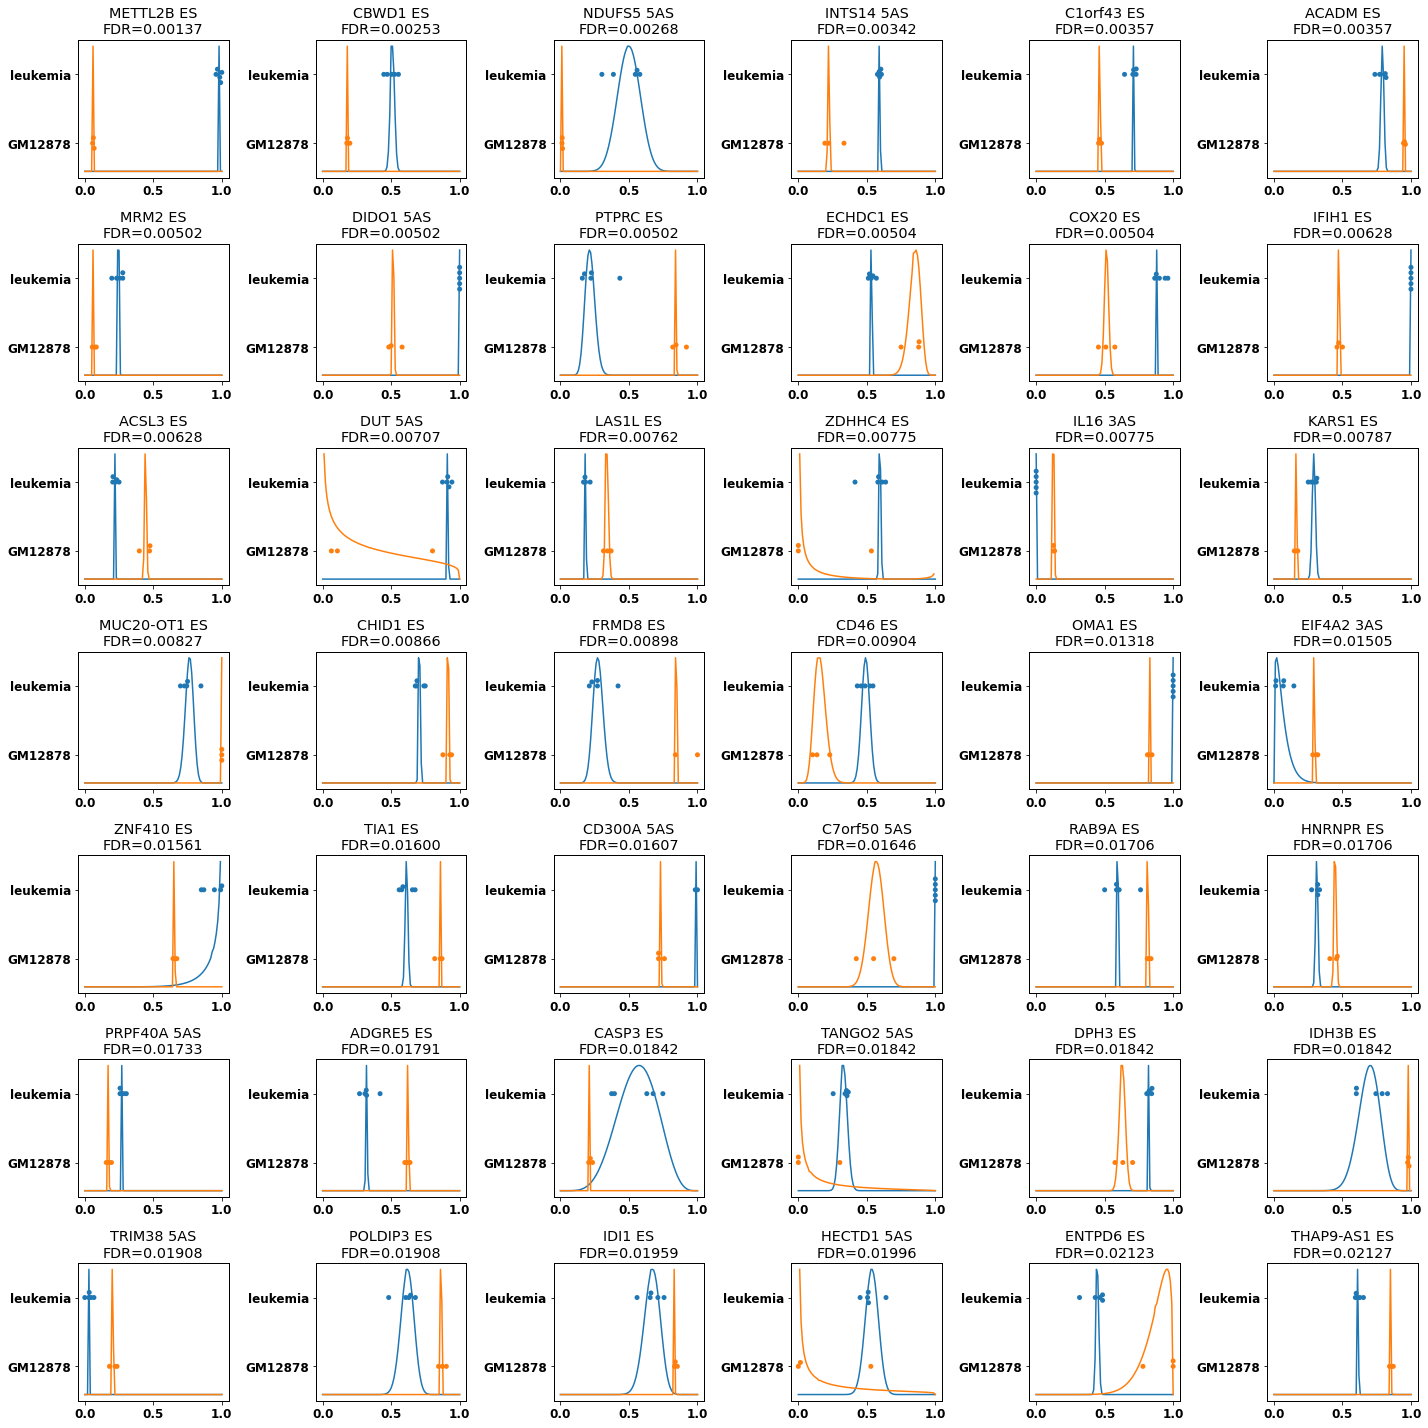

In [27]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

METTL2B ES (known) FDR=1.37e-03: leukemia=98.2 vs GM12878=6.2 PSI


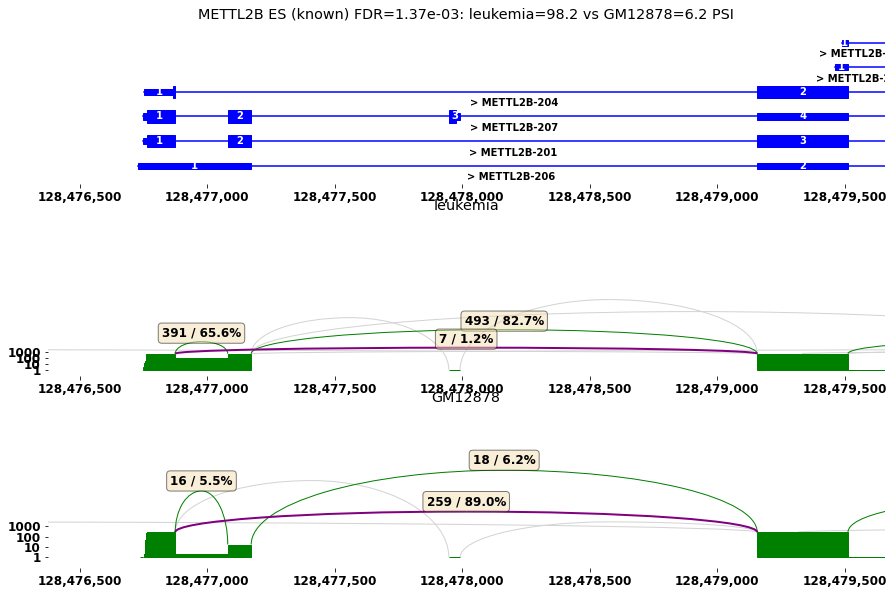

In [28]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[3]
plot_diff_example(row, isoseq, groups)